# IML Assignment 2 - Roshni Pai, Vatsl Goswami

## 1. Introduction
### Explaining the Dataset
The _Synthetic Circles_ data-set is a structured dataset containing:
- *Instances*: 10,000
- *Features*: 2

All the datapoints are divided into 100 'hollow' circles. These form a *non-convex* shape over $\mathbb{R}^2$, and thus provide insight into how different clustering algorithms perform.

### Objective
The objective of this notebook is to get a hands-on experience with:
- Exploring the dataset
- Performing different pre-processing techinques
- Writing clustering algorithms from scratch
- Choosing the right hyper-parameters by testing
- Evaluating the performance of our models using metrics like DB-Index and Silhouette Scores.

Our focus is not on *achieving the best results* but ensuring we follow the *correct process*. As a result, at many points in our code, we've made the decision to not tweak our models just to achieve better metrics, but rather according to the methods (for e.g., Elbow Method) prescribed in lectures. Hopefully, our sincerity comes through as you follow-along our code. 

## 2. Exploratory Data Analysis

### Basic Data Checks
2. Exploratory Data Analysis (EDA)
   -  Summarize the datasets: number of samples, features, data types, missing values.
   -  Visualize important feature distributions and correlations.
   -  Identify any potential data quality issues.

In [308]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import random
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import adjusted_rand_score

In [309]:
# Loading the dataset and printing the shape
df = pd.read_csv("data/dataset1.txt")

display(df.head())
print(df.shape)

,x,y,class
0,3.15676,116.12252,6
1,16.14436,16.81660,11
2,100.31212,64.99025,53
3,-1.33773,84.81772,4
4,104.37328,62.42373,53


(10000, 3)


In [310]:
#Understanding the data-types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10000 non-null  float64
 1   y       10000 non-null  float64
 2   class   10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 234.5 KB
None


In [428]:
# Checking for null-values
display(df.isnull().sum())
display(df.duplicated().sum())

x        0
y        0
class    0
dtype: int64

0

In [312]:
# Calculating measures of central tendency
df.describe()

,x,y,class
count,10000.000000,10000.000000,10000.000000
mean,89.981670,90.003827,49.500000
std,57.457467,57.559719,28.867513
min,-5.000000,-4.999860,0.000000
25%,40.237885,40.133840,24.750000
50%,89.999995,90.000080,49.500000
75%,139.898800,139.977695,74.250000
max,184.999920,185.000000,99.000000


### Results of above code:
We can see that the dataset has the following features:
- *Instances*: 10,000
- *Features*: 2 --- we are given coordinates of points $(x,y)$ where both features are floats, i.e. they belong to $\mathbb{R}$.
- *Nulls & Duplicates*: Since the data is synthetically generated, there are **no null and duplicate** values that we will need to separately handle.

### Visualising the Dataset

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


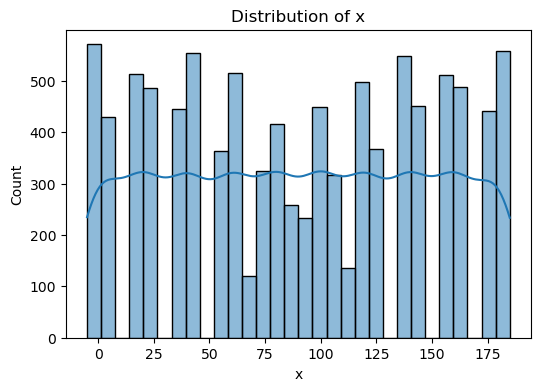

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


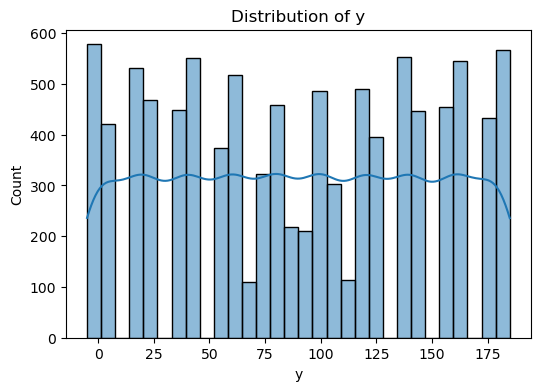

In [313]:
# Plotting the distribution of x, y
for col in df.columns:
    if col == "class":
        continue
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

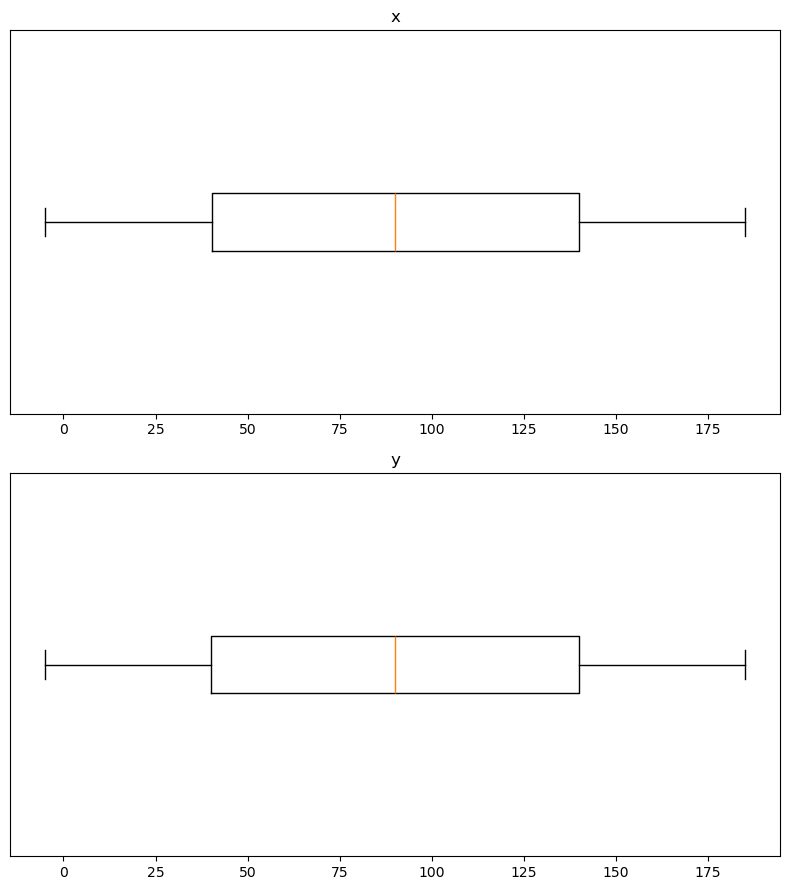

In [314]:
# Box-plots of x,y to check for any outliers

fig, axs = plt.subplots(len(df.columns)-1, 1, figsize=(8, 3*len(df.columns)), dpi=100)

if len(df.columns) == 1:
    axs = [axs]

for i, col in enumerate(df.columns):
    if col=="class":
        continue
    axs[i].boxplot(df[col].dropna(), vert=False)
    axs[i].set_title(col)   
    axs[i].set_yticks([]) 

plt.tight_layout()
plt.show()

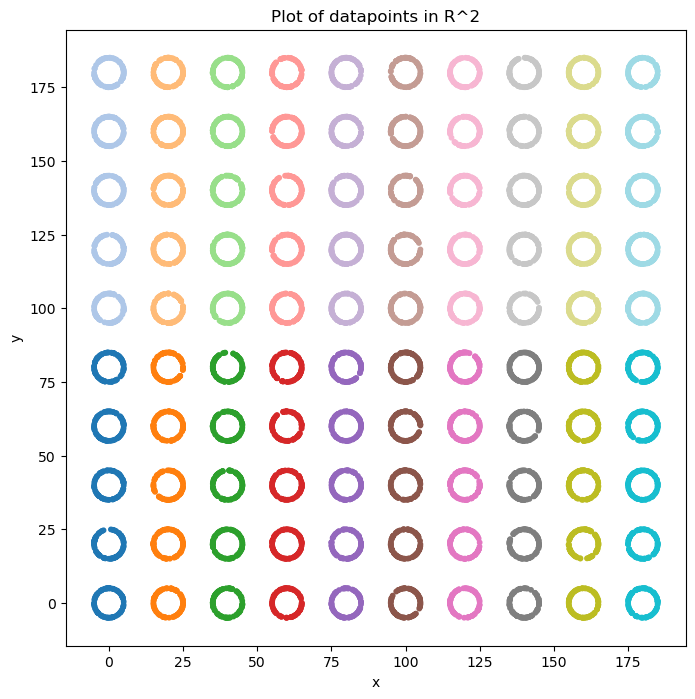

In [315]:
# Scatter plot of all our data-points in R^2

plt.figure(figsize = (8,8))
plt.scatter(df["x"], df["y"],c=df['class'], cmap="tab20", s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of datapoints in R^2")
plt.show()

### Results of above code:
From the above histogram & box plots, we can see that:
- $x,y$ are evenly distributed and have **no outliers**.
- Our dataset forms multiple non-convex, hollow circle shaped clusters in $\mathbb{R}^2$. Thus, this creates a **conflict** with the assumptions of algorithms like `kMeans` and `GMMs`, which assume that our clusters form dense, spherical blobs.
- *Hypothesis*: density-based algorithms like `DBScan` will work much better in representing our dataset than `kMeans/GMM`.

## 3. Data-Preprocessing
Since the data has no categorical variables, null/duplicate values, the only pre-processing step we need to follow is *standardization of our input features.* This ensures that all the inputs are centred around 0, which is very important for algorithms that rely on Euclidean distances to decide cluster membership.

In [430]:
# Splitting our input and output columns
X = df[["x", "y"]].copy()
y = df['class'].copy()

In [431]:
# Performing z-score normalization on our inputs

def standardize(col):
    mu = X[col].mean()
    sigma = X[col].std()
    X.loc[:, col] = (X[col] - mu)/sigma

for col in X.columns:
    standardize(col)

display(X.head())

,x,y
0,-1.511116,0.453767
1,-1.285078,-1.271501
2,0.179793,-0.434567
3,-1.589339,-0.090100
4,0.250474,-0.479156


## 4. Clustering Methods
### Algo 1: K-Means Clustering

In [318]:
# func to calculate euclidean distance between two points.
def norm(p1, p2):
    return sqrt((p2['x']-p1['x'])^2 + (p2['y']-p1['y'])^2)

In [319]:
# k-means clustering
def k_means(X, k, max_iter=20, tol=1e-5, random_state=None):
    # setting up numpy random number generator to sample our initial k-centroids
    rng = np.random.default_rng(seed=random_state)

    n_samples = X.shape[0]
    n_features = X.shape[1]
   
    # Step 1: Initialize centroids (random sample of k points)
    idx = rng.choice(n_samples, size=k, replace=False)
    centers = X[idx, :]
    # this will store values of J (Within Cluster SSE) for each iteration -- useful to plot gradient descent
    obj_func = []

    for iteration in range(max_iter):
        # Step 2: Assign points to nearest centroid
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2) 
        labels = np.argmin(dists, axis=1)  # nearest centroid for each point

        # Step 2b: Calculate objective (WCSS)
        J = np.sum((X - centers[labels])**2)
        obj_func.append(J)

        # Step 3: Recompute centroids
        new_centers = np.zeros_like(centers)
        for cluster_idx in range(k):
            members = X[labels == cluster_idx]
            if len(members) > 0:
                new_centers[cluster_idx] = members.mean(axis=0)
            else:
                # reinitialize cluster if empty
                new_centers[cluster_idx] = X[rng.integers(0, n_samples)]

        # Check if we have converged
        shift = np.linalg.norm(new_centers - centers)
        if shift < tol:
            centers = new_centers
            break

        centers = new_centers

    return centers, labels, obj_func

### Choosing `max-iter`, `tol`
We plot the graph of $J$ over our iterations to see at which iteration our algorithm stops improving. From the plot below, we can see clearly that **after the 20th iteration* we do not make any improvements in our objective function $J$.  

**_Choice of hyper-param_**: Set `max_iter` = 20   
Set `tol` = $1^{-5}$  because that is the industry-standard for standardized data. Regardless, our function will stop according to our `max_iter` value before it converges according to the `tol`.

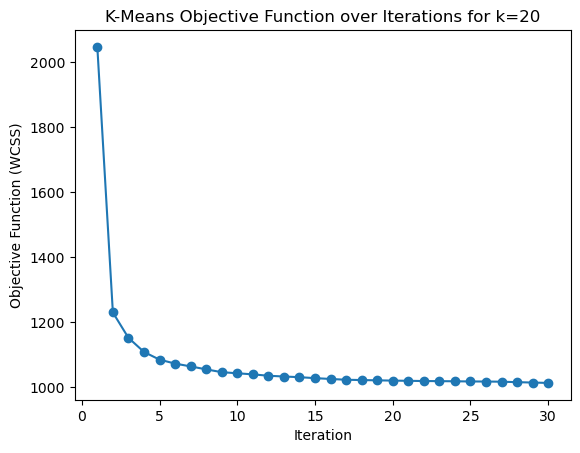

In [443]:
k = 20
centers, labels, objectives = k_means(X, k=k, max_iter = 30)

plt.plot(range(1, len(objectives)+1), objectives, marker = 'o')
plt.xlabel("Iteration")
plt.ylabel("Objective Function (WCSS)")
plt.title(f"K-Means Objective Function over Iterations for k={k}")
plt.show()

### Choosing `k` (no. of clusters) using Elbow Method
While we know that our dataset is divided into 100 seperate circles (clusters). This value of $k$ need not necessarily provide the best clustering for our `kMeans` algorithm. This is primarily because as explained before, the algorithm only works for convex clusters.

Hence, we choose the best value of `k` using the *Elbow Method*. Here, we plot the WCSS for $k \in [1, 200]$ and see at which point we get diminishing returns. That is, choosing the elbow point value for $k$ gives us the best trade-off between maximizing the cluster density along with not choosing too small cluster sizes.

In our data, we can see the data has an elbow point near 25. Thus, we choose our hyperparameter `k` = 30.

In [424]:
inertias = []
for k in range(1, 200):
    centers, labels, objectives = k_means(X, k=k)
    inertias.append(objectives[-1])
    print(f"Inertia done for k={k}")

Inertia done for k=1
Inertia done for k=2
Inertia done for k=3
Inertia done for k=4
Inertia done for k=5
Inertia done for k=6
Inertia done for k=7
Inertia done for k=8
Inertia done for k=9
Inertia done for k=10
Inertia done for k=11
Inertia done for k=12
Inertia done for k=13
Inertia done for k=14
Inertia done for k=15
Inertia done for k=16
Inertia done for k=17
Inertia done for k=18
Inertia done for k=19
Inertia done for k=20
Inertia done for k=21
Inertia done for k=22
Inertia done for k=23
Inertia done for k=24
Inertia done for k=25
Inertia done for k=26
Inertia done for k=27
Inertia done for k=28
Inertia done for k=29
Inertia done for k=30
Inertia done for k=31
Inertia done for k=32
Inertia done for k=33
Inertia done for k=34
Inertia done for k=35
Inertia done for k=36
Inertia done for k=37
Inertia done for k=38
Inertia done for k=39
Inertia done for k=40
Inertia done for k=41
Inertia done for k=42
Inertia done for k=43
Inertia done for k=44
Inertia done for k=45
Inertia done for k=

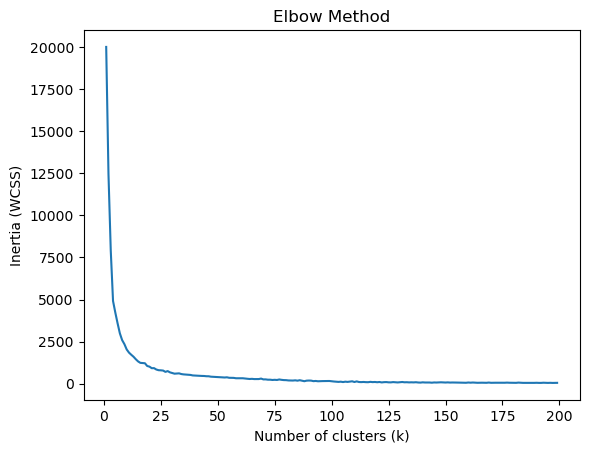

In [425]:
ks = range(1, len(inertias) + 1)

plt.plot(ks, inertias)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")
plt.show()

## Visualizing the Results

Running `kMeans` on our dataset, for $k=30$, we see that the model ends up clustering multiple circles into 1 cluster. Roughly $3-4$ circles get grouped together. This is much better than what would happen for larger values of $k$, where the algorithm would divide the circle into weird partitions since our centroids could never get updated to reach the center of each circle (becuse no datapoints exist inside our rings).

Below is a clear visualization of our data in $\mathbb{R}^2$. The cross-marks represent the centroids for each number/label.

In [322]:
#Choose k = 30 and max_iter = 30 based on graphs above
k = 30
max_iter = 30
centers, labels_kmeans, objectives = k_means(X, k=k, max_iter = max_iter)

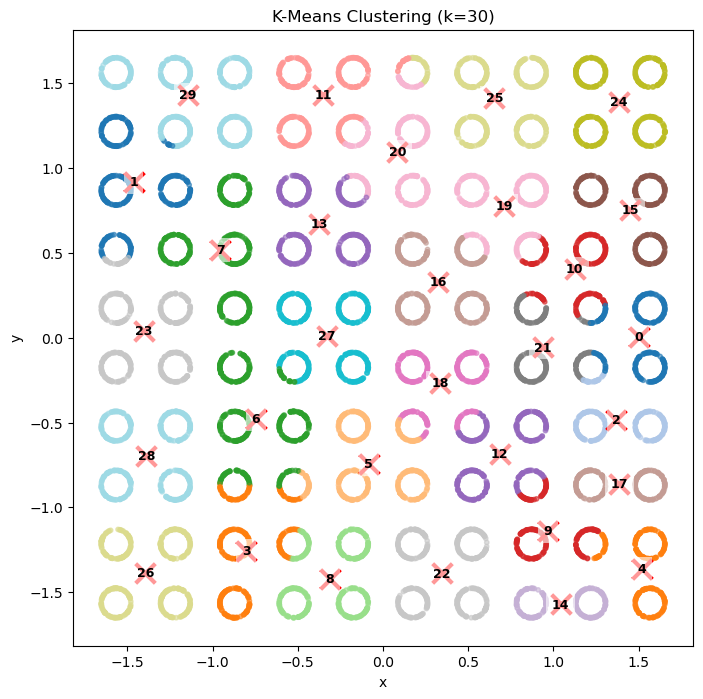

In [323]:
plt.figure(figsize=(8,8))

# Scatter plot colored by cluster labels
plt.scatter(X[:,0], X[:,1], c=labels_kmeans, cmap='tab20', s=10, alpha=0.6)

# Overlay centroids as large red X's
plt.scatter(centers[:,0], centers[:,1], c='red', marker='x', s=200, linewidths=3)


# Annotate each centroid with its cluster ID
for idx, (cx, cy) in enumerate(centers):
    plt.text(cx, cy, str(idx), fontsize=9, fontweight = "bold", color='black',
             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title(f"K-Means Clustering (k={k})")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Performance Metrics of `kMeans`

As expected, our `kMeans` algorithm does not provide a very good clustering of this dataset. Clearly, it is unable to capture the data's weird structure.

The **Silhouette Score** is $0.36$. This is primarily because of the large intra-cluster distances between the circles that actually belong to separate classes in our original labelling.

The high **DB-Index** of $0.85$ also suggests the clustering is not great.

We also tested using the **Adjusted-Rand Index** since we were given the labels for each class. A score of $0.4$ suggests the data retains a decent amount of the original structure---but there is lot of scope for improvement.

In [369]:
score = silhouette_score(X, labels_kmeans)
print(f"Silhouette Score: {score}")

score = davies_bouldin_score(X, labels_kmeans)
print(f"DB-Index: {score}")

ari = adjusted_rand_score(y, labels_kmeans)
print(f"Adjused-Rand Index: {ari}")

Silhouette Score: 0.3624636849521206
DB-Index: 0.8523002535275256
Adjused-Rand Index: 0.39214263535750177


### Algo 2: DBScan

In [327]:
# finding all points within an epsilon distance of p= X[idx]
def find_neighbors(X, idx, eps):
    dist = np.linalg.norm(X-X[idx], axis=1)
    return np.where(dist<=eps)[0]

def dbscan(X, minPts=4, eps=2):
    n = X.shape[0] #total number of datapoints

    #define labels for unvisited and noise
    unvisited = -2 
    noise = -1
    labels = np.full(n, unvisited, dtype=int)
    cluster_id = 0

    for i in range(n):

        if labels[i] != unvisited:
            continue #point was already processed

        neighbors = find_neighbors(X, i, eps)

        # not a core point (enough to start a new cluster)
        if neighbors.size < minPts:
            labels[i] = noise
            continue
            
        #if a core point, start a new cluster
        cluster_id += 1
        labels[i] = cluster_id
        pts_to_check = [i for i in neighbors]

        #explore all the points neighbors for potential members of the new cluster
        while pts_to_check:
            j = pts_to_check.pop()
            
            if labels[j] == noise:
                labels[j] = cluster_id #non-core pts become borders of our cluster but cannot expand the cluster

            if labels[j] != unvisited:
                continue 
                
            labels[j] = cluster_id
            j_neighbors = find_neighbors(X, j, eps)

            #if j is a core-point, add its neighbors to our pts_to_check
            if j_neighbors.size >= minPts:
                for nb in j_neighbors:
                    if labels[nb] in [unvisited, noise]:   
                        pts_to_check.append(nb)
    return labels     
        

### Choosing `eps` using Elbow Method
Once again, we use the Elbow Method to choose the parameter `eps`. To do this, we first fix our `minPts` to values roughly $~ 2\cdotD$ where D is the no. of dimensions. This is gives us a range of the no. of points we want to consider to be a core point. The number is proportional to the dimensions of our input-space since the larger our input space gets, the more sparse our data. Thus, we need more points to define a dense region/cluster.

Using this, we plot the max-distance of the epsilon neighbors of all our points. The elbow of this graph, gives us a good, efficient value of `eps`, which can be used to define clusters.

From our graphs, we choose eps-values as follows (on right), along with their corresponding minPts value (in the left side):
- $4 \rightarrow \epsilon = 0.0175$
- $5\rightarrow \epsilon = 0.021$
- $6\rightarrow \epsilon = 0.025$
- $7\rightarrow \epsilon = 0.03$
- $8 \rightarrow \epsilon = 0.034$


In [328]:
minPts = [4,5,6,7,8]
def plot_elbow_DBSCAN(n_neighbors):
    k = n_neighbors
    nbrs = NearestNeighbors(n_neighbors = k).fit(X)
    distances, idx = nbrs.kneighbors(X)

    kdist = distances[:, -1]
    kdist_sorted = np.sort(kdist)[::-1]

    plt.figure(figsize=(6,4))
    plt.plot(kdist_sorted)
    plt.xlabel("Points (sorted)")
    plt.ylabel(f"{k}-NN distance")
    plt.title(f"k-distance elbow plot (minPts={k})")
    plt.grid(alpha=0.3)
    plt.show()

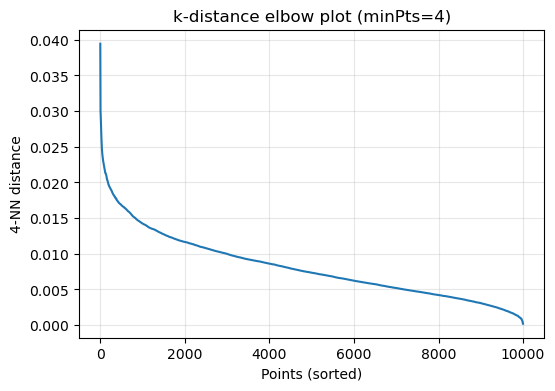

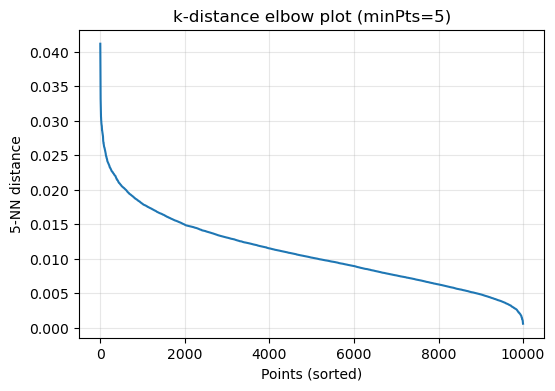

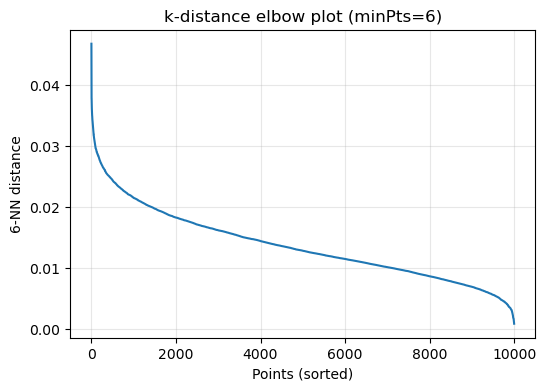

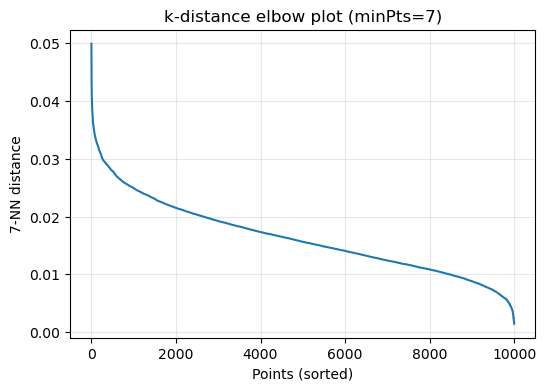

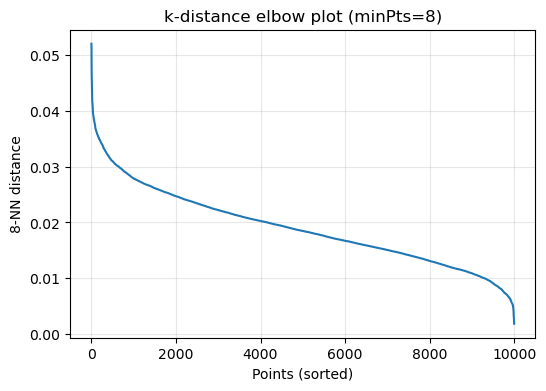

In [329]:
for minPt in minPts:
    plot_elbow_DBSCAN(minPt)

### Choosing `minPts`
We now check the Silhouette Scores of our `DBSCAN` for our chosen values of `minPts` and their corresponding fixed $\epsilon$ values. Now, choose the pair hwich gives us the best Silhouette Score.

Thus, we choose: `minPts` $= 8$, `eps` $= 0.034$ 


In [353]:
minpts_eps = {
    4: 0.0175,
    5: 0.021,
    6: 0.025,
    7: 0.03,
    8: 0.034
}

for minPt, eps in minpts_eps.items():
    labels = dbscan(X, minPt, eps)
    print(f"Silhouette Score for minPts={minPt}: {(silhouette_score(X,labels))}")

Silhouette Score for minPts=4: 0.39532746950426684
Silhouette Score for minPts=5: 0.4137459716483472
Silhouette Score for minPts=6: 0.4569009878656834
Silhouette Score for minPts=7: 0.5658560465519425
Silhouette Score for minPts=8: 0.5913940933181553


### Visualizing the Results

The plots below show us that the DBSCAN algorithm understands the non-convex structure of our dataset much better. It identifies **107** clusters, much closer to the original $100$, and also labels larger portions of the circles into 1 cluster. 

In [365]:
minpts = 8
eps = 0.034
labels_dbscan_new = dbscan(X, minPts=minpts, eps=eps)

# unique labels
unique_labels = np.unique(labels_dbscan_new)

# exclude noise (-1)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels_dbscan== -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 107
Noise points: 8


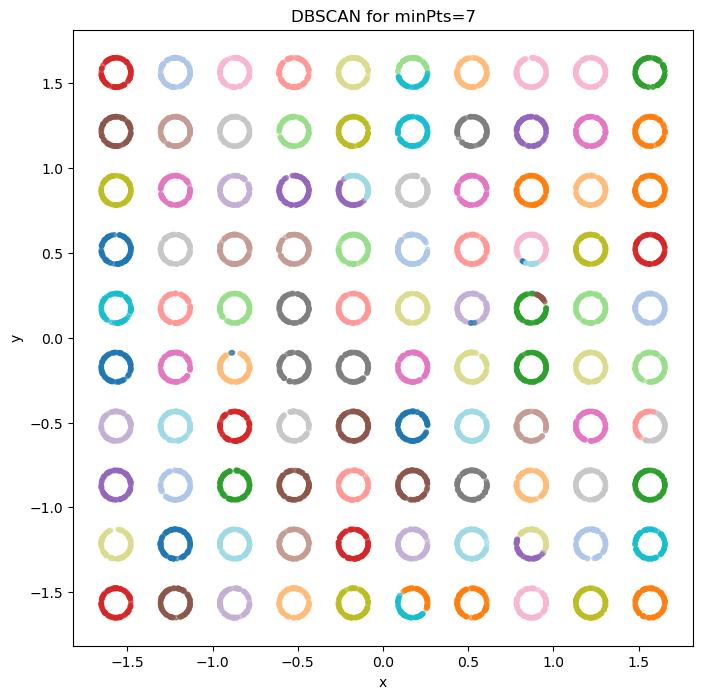

In [366]:
plt.figure(figsize=(8,8))

# Scatter plot colored by cluster labels
plt.scatter(X[:,0], X[:,1], c=labels_dbscan_new, cmap='tab20', s=10, alpha=0.6)

plt.title(f"DBSCAN for minPts=7")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

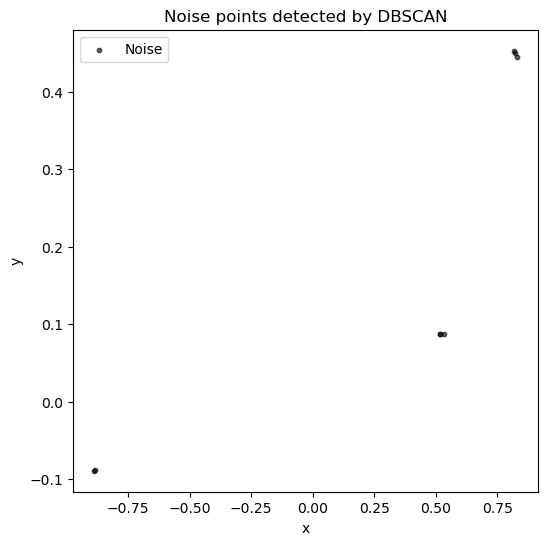

In [367]:
# Get noise points (labels == -1)

noise_points = X[labels_dbscan_new == -1]

plt.figure(figsize=(6,6))

# plot noise points only
plt.scatter(noise_points[:,0], noise_points[:,1], c='black', s=10, alpha=0.6, label="Noise")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Noise points detected by DBSCAN")
plt.legend()
plt.show()

## Performance Metrics
Clearly, DBScan creates more *well-formed* clusters as reflected in it's higher **Silhouette Score** and lower **DB Index**.

The algorithm also does **amazing** in retrieving the original labels of our dataset. This is seen in its almost perfect **Rand-Index** of $0.98$.

In [372]:
mask = labels_dbscan_new != -1
labels_eval = labels_dbscan_new[mask]
X_eval = X[mask]

sil_score = silhouette_score(X_eval, labels_eval)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_eval, labels_eval)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y[mask], labels_eval)
print(f"Adjusted-Rand Index: {ari}")

Silhouette Score: 0.592567059420955
DB-Index: 0.5632768587603503
Adjusted-Rand Index: 0.9842376665976712


## Why does DBSCAN do better than kMeans for this Dataset?
DBSCAN performs much better than kMeans for this dataset because of the following reasons:
- *Each cluster has roughly the same density.* Hence, our single choice of `eps` works very well in clustering all the different circles.
- *The clusters are non-convex*. `kMeans` assumes clusters are convex. Meanwhile, `DBSCAN` simply clusters data based on density of points. Hence, it works better for all kinds of shapes compared to `kMeans`.
- *Input space has low dimensionality*. `kMeans` is simple and thus can work well even in larger-dimensional spaces. Meanwhile, as the dimensionality increases, the datapoints become more sparse and hence density-based algorithms like `DBSCAN` would **struggle to define clusters**. 

PCA(2) explained variance ratio: [0.50050531 0.49949469]
PCA(1) explained variance ratio: [0.50050531]


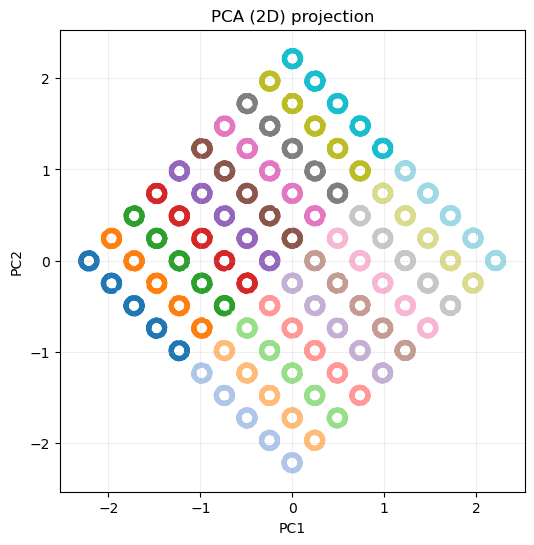

In [378]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)
print("PCA(2) explained variance ratio:", pca2.explained_variance_ratio_)

# --- 2b) PCA to 1D (project onto PC1) ---
pca1 = PCA(n_components=1)
X_pca1 = pca1.fit_transform(X).ravel()
print("PCA(1) explained variance ratio:", pca1.explained_variance_ratio_)

# --- 3) Plots ---

# 3a) 2D PCA scatter
plt.figure(figsize=(6,6))

plt.scatter(X_pca2[:,0], X_pca2[:,1], c=df['class'], cmap="tab20", s=8, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2D) projection")
plt.grid(alpha=0.2)
plt.show()

In [387]:
minpts = 8
eps = 0.034
labels_dbscan_pca2 = dbscan(X_pca2, minPts=minpts, eps=eps)

# unique labels
unique_labels = np.unique(labels_dbscan_pca2)

# exclude noise (-1)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels_dbscan_pca2== -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 107
Noise points: 8


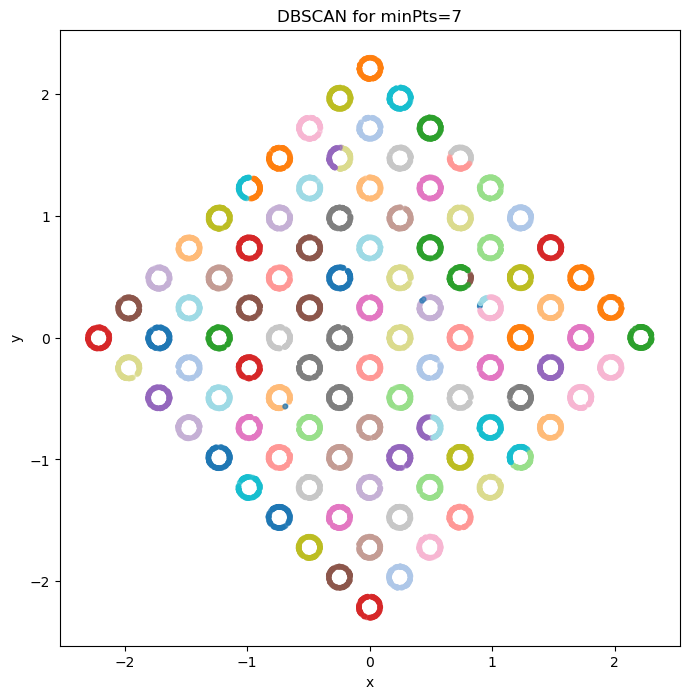

In [388]:
plt.figure(figsize=(8,8))

# Scatter plot colored by cluster labels
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_dbscan_pca2, cmap='tab20', s=10, alpha=0.6)

plt.title(f"DBSCAN for minPts=7")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

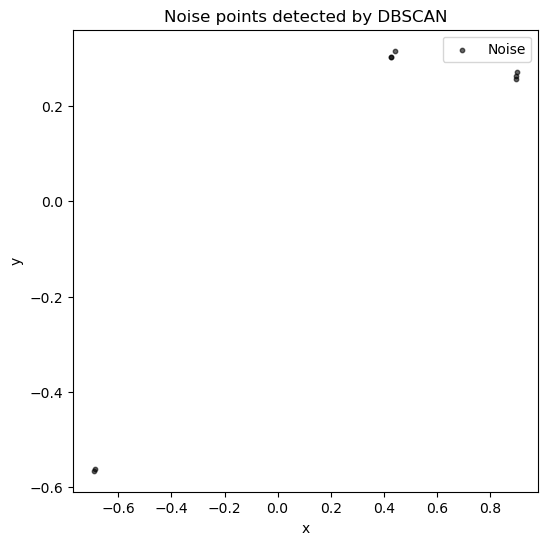

In [389]:
# Get noise points (labels == -1)
noise_points = X_pca2[labels_dbscan_pca2 == -1]

plt.figure(figsize=(6,6))

# plot noise points only
plt.scatter(noise_points[:,0], noise_points[:,1], c='black', s=10, alpha=0.6, label="Noise")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Noise points detected by DBSCAN")
plt.legend()
plt.show()

In [392]:
mask = labels_dbscan_pca2 != -1
labels_eval_pca2 = labels_dbscan_pca2[mask]
X_eval_pca2 = X_pca2[mask]

sil_score = silhouette_score(X_eval_pca2, labels_eval_pca2)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_eval_pca2, labels_eval_pca2)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y[mask], labels_eval_pca2)
print(f"Adjusted-Rand Index: {ari}")

Silhouette Score: 0.5925670594209552
DB-Index: 0.5632768587603517
Adjusted-Rand Index: 0.9842376665976712


In [393]:
X_pca1 = X_pca1[:, None]
X_pca1.shape

(10000, 1)

In [397]:
#Choose k = 30 and max_iter = 30 based on graphs above
k = 30
max_iter = 30
centers, labels_kmeans, objectives = k_means(X_pca2, k=k, max_iter = max_iter)

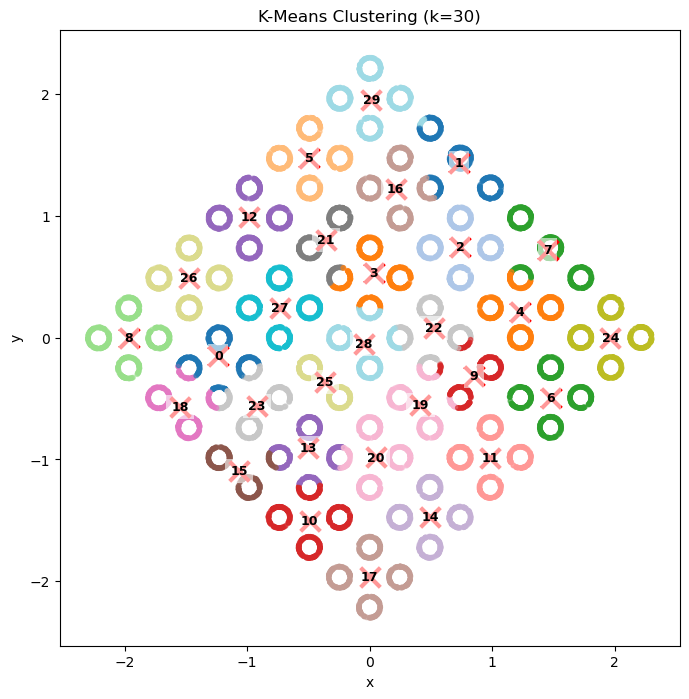

In [398]:
plt.figure(figsize=(8,8))

# Scatter plot colored by cluster labels
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_kmeans, cmap='tab20', s=10, alpha=0.6)

# Overlay centroids as large red X's
plt.scatter(centers[:,0], centers[:,1], c='red', marker='x', s=200, linewidths=3)


# Annotate each centroid with its cluster ID
for idx, (cx, cy) in enumerate(centers):
    plt.text(cx, cy, str(idx), fontsize=9, fontweight = "bold", color='black',
             ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title(f"K-Means Clustering (k={k})")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [399]:
score = silhouette_score(X_pca2, labels_kmeans)
print(f"Silhouette Score: {score}")

score = davies_bouldin_score(X_pca2, labels_kmeans)
print(f"DB-Index: {score}")

ari = adjusted_rand_score(y, labels_kmeans)
print(f"Adjused-Rand Index: {ari}")

Silhouette Score: 0.3812702823372312
DB-Index: 0.8035788749599238
Adjused-Rand Index: 0.4051643230112585


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


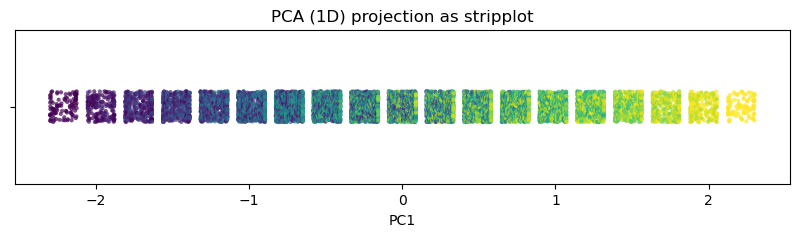

In [403]:
# 3b) 1D PCA “strip” plot (points on a line). Sort for readability.
# Ensure 1-D arrays
x1 = np.asarray(X_pca1).ravel()     
y_labels = np.asarray(y).ravel()

order = np.argsort(x1)
x1_sorted = x1[order]
c_sorted  = y_labels[order]


plt.figure(figsize=(10,2))
sns.stripplot(x=x1_sorted, palette="viridis", hue=c_sorted, size=3, alpha=0.7, legend=False)
plt.xlabel("PC1")
plt.title("PCA (1D) projection as stripplot")
plt.show()

In [404]:
#Choose k = 30 and max_iter = 30 based on graphs above
k = 30
max_iter = 30
centers, labels_pca1, objectives = k_means(X_pca1, k=k, max_iter = max_iter)

In [405]:
sil_score = silhouette_score(X_pca1, labels_pca1)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_pca1, labels_pca1)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y, labels_pca1)
print(f"Adjusted Rand Index: {ari}")

Silhouette Score: 0.6102666060831451
DB-Index: 0.458614600396248
Adjusted Rand Index: 0.2315367901439368


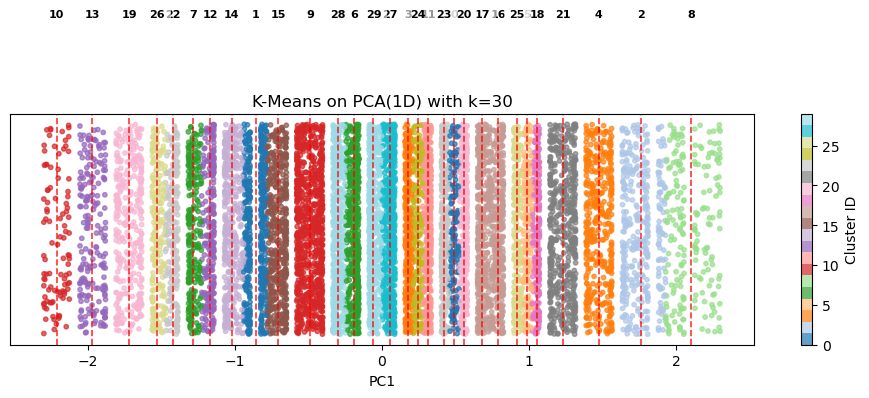

In [407]:
# Ensure shape (n,)
x1 = np.asarray(X_pca1).ravel()
labels_pca1 = np.asarray(labels_pca1).ravel()
centers_1d = np.asarray(centers).ravel()

# Add vertical jitter for visibility
rng = np.random.default_rng(0)
y_jitter = rng.uniform(-0.05, 0.05, size=len(x1))

plt.figure(figsize=(12, 3))

# Plot points colored by cluster assignment
sc = plt.scatter(x1, y_jitter, c=labels_pca1, cmap='tab20', s=10, alpha=0.7)

# Plot centroid vertical lines
for idx, cx in enumerate(centers_1d):
    plt.axvline(cx, color='red', linestyle='--', linewidth=1.2, alpha=0.8)
    plt.text(cx, 0.1, str(idx), fontsize=8, fontweight="bold", color='black',
             ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.xlabel("PC1")
plt.yticks([])   # hide y-axis, just a strip
plt.title(f"K-Means on PCA(1D) with k={k}")
plt.colorbar(sc, label="Cluster ID")
plt.show()


In [410]:
minpts = 8
eps = 0.034
labels_dbscan_pca1= dbscan(X_pca1, minPts=minpts, eps=eps)

# unique labels
unique_labels = np.unique(labels_dbscan_pca1)

# exclude noise (-1)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels_dbscan_pca1 == -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 19
Noise points: 0


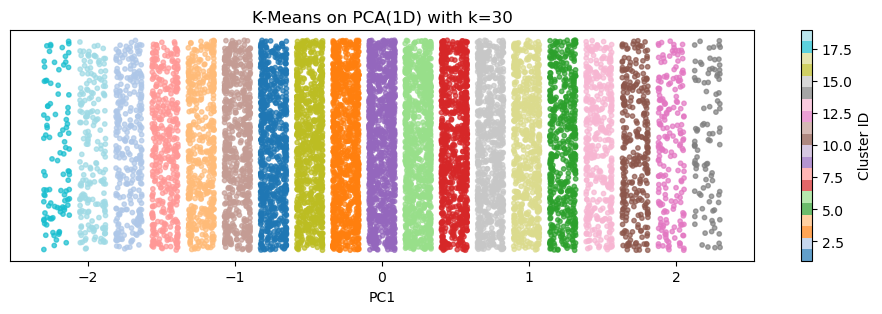

In [411]:
# Ensure shape (n,)
x1 = np.asarray(X_pca1).ravel()
labels_pca1 = np.asarray(labels_pca1).ravel()
centers_1d = np.asarray(centers).ravel()

# Add vertical jitter for visibility
rng = np.random.default_rng(0)
y_jitter = rng.uniform(-0.05, 0.05, size=len(x1))

plt.figure(figsize=(12, 3))

# Plot points colored by cluster assignment
sc = plt.scatter(x1, y_jitter, c=labels_dbscan_pca1, cmap='tab20', s=10, alpha=0.7)

plt.xlabel("PC1")
plt.yticks([])   # hide y-axis, just a strip
plt.title(f"K-Means on PCA(1D) with k={k}")
plt.colorbar(sc, label="Cluster ID")
plt.show()


In [412]:
sil_score = silhouette_score(X_pca1, labels_dbscan_pca1)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_pca1, labels_dbscan_pca1)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y, labels_dbscan_pca1)
print(f"Adjusted Rand Index: {ari}")

Silhouette Score: 0.6148081404699866
DB-Index: 0.4541411501564446
Adjusted Rand Index: 0.24478551751279023


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


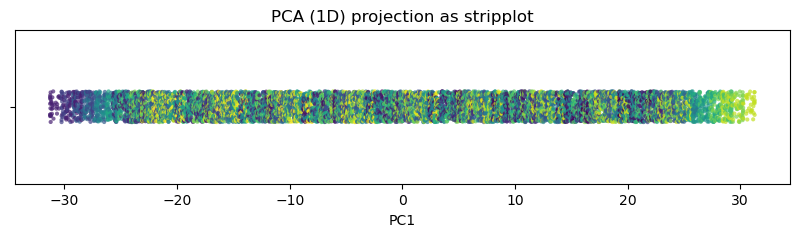

In [416]:
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y).ravel()   # shape (n,)

x1 = np.asarray(X_lda1).ravel()     
y_labels = np.asarray(y).ravel()

order = np.argsort(x1)
x1_sorted = x1[order]
c_sorted  = y_labels[order]


plt.figure(figsize=(10,2))
sns.stripplot(x=x1_sorted, palette="viridis", hue=c_sorted, size=3, alpha=0.7, legend=False)
plt.xlabel("PC1")
plt.title("PCA (1D) projection as stripplot")
plt.show()

In [417]:
X_lda = X_lda[:, None]
X_lda.shape

(10000, 1)

In [419]:
minpts = 8
eps = 0.034
labels_dbscan_lda= dbscan(X_lda, minPts=minpts, eps=eps)

# unique labels
unique_labels = np.unique(labels_dbscan_lda)

# exclude noise (-1)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels_dbscan_lda == -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 175
Noise points: 419


In [420]:
#Choose k = 30 and max_iter = 30 based on graphs above
k = 30
max_iter = 30
centers, labels_lda, objectives = k_means(X_lda, k=k, max_iter = max_iter)

In [421]:
labels_dbscan_lda = labels_dbscan_lda.ravel()
labels_dbscan_lda.shape

(10000,)

In [422]:
sil_score = silhouette_score(X_lda, labels_dbscan_lda)
print(f"Silhouette Score: {sil_score}")

db_score = davies_bouldin_score(X_lda,labels_dbscan_lda)
print(f"DB-Index: {db_score}")

ari = adjusted_rand_score(y, labels_dbscan_lda)
print(f"Adjusted Rand Index: {ari}")

Silhouette Score: 0.3486021029995055
DB-Index: 6.167383659565024
Adjusted Rand Index: 0.16571674397042896
